In [ ]:
# Import 

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd 
import seaborn as sns 
from datetime import date
import time 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Toys dataset
This class generates MCAR, MAR and MNAR datasets. 

In [ ]:
# covariance matrice 
def ind(i,j,k):
    # separates &,n into k blocks
    return int(i//k==j//k)


# Rank k-blocks covariance matrix : 
U=np.array([[ind(i,j,2) for j in range(10)] for i in range(10)])


# One Toeplitz matrix  
def toep (d):
  return np.array([[ (0.6)**abs(i-j) for i in range(d)]for j in range(d)])
print('U=')
print(U)
print('T=')
print(toep(6))

U=
[[1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1]]
T=
[[1.      0.6     0.36    0.216   0.1296  0.07776]
 [0.6     1.      0.6     0.36    0.216   0.1296 ]
 [0.36    0.6     1.      0.6     0.36    0.216  ]
 [0.216   0.36    0.6     1.      0.6     0.36   ]
 [0.1296  0.216   0.36    0.6     1.      0.6    ]
 [0.07776 0.1296  0.216   0.36    0.6     1.     ]]



**Scenarios:**


1.    MCAR anisotropic: $M$ Bernoulli, $X \sim\mathcal{N}(0,U)$.  
2. MAR: $X_1,...,X_k$ always observed, and $M_j=f(X_1,...,X_k)$ for $j>k$. 
3. MNAR-GMM: $X|M=m\sim\mathcal{N}(\mu_m,I)$.








In [ ]:
class ToysMissingDataset ():
    def __init__(self, n=1000,d=10,sigma=1, method='MCAR_cor',p=0.1,k=2,A=None,R=1):
        self.n= n
        self.d=d
        self.method = method # method used to build dataset 
        self.X = np.zeros((n,d))
        self.M= np.zeros((n,d)) # na occurences 
        self.beta = R*np.ones(d)/d
        self.sigma= sigma
        self.y = np.zeros(n)
        self.p=p
        self.k=k # number of blocks in covariance matrix
        self.A=A # A=B,w where M_j= 1_(B_j@X +w_j)

        self.build(self.n)


    def build(self,n): 
      # build n observations according to a method 
        self.n=n
        self.X = np.zeros((n,self.d))
        self.M= np.zeros((n,self.d))
        if self.method =='MCAR_iso': 
            # Generate un simpler MCAR distribution, with isotrope observation 
            self.X= np.random.normal(size=(self.n,self.d))
            self.M= np.random.binomial(n=1,p=self.p, size=(self.n,self.d))

        elif self.method =='MCAR_cor': 
            # Generate un simpler MCAR distribution, with anisotropic observations and Sigma=U
            U= np.array([[ind(i,j,self.k) for j in range(self.d)] for i in range(self.d)])/np.sqrt(self.k)
            self.X= np.random.normal(size=(self.n,self.d))@U+np.ones(self.d)
            self.M= np.random.binomial(n=1,p=self.p, size=(self.n,self.d))

        elif self.method =='MCAR_cor2': 
            # Generate un simpler MCAR distribution, with anisotropic observations and Sigma=Toepliz
            
            self.X= np.random.multivariate_normal(np.zeros(self.d),toep(self.d),size=self.n)
            self.M= np.random.binomial(n=1,p=self.p, size=(self.n,self.d))
            
        
        elif self.method =='MAR': 
            # Generate un simpler masked MAR distribution, with non isotrope observations
            kmar=self.d//2
            kb=self.d-kmar
            self.X= np.random.multivariate_normal(np.zeros(self.d),np.identity(self.d),size=self.n)
            self.M[:,kmar:]= np.random.binomial(n=1,p=self.p, size=(self.n,kb))*(np.array(self.X[:,:kmar]>0))
            self.X[:,kmar:]=self.X[:,kmar:]@np.ones((kb,kb))/np.sqrt(kb)+5*self.M[:,kmar:]


        elif self.method =='Database_merge': 
          # self.A= list of hospital, self.A[0]: mean , self.A[1]: covariance , self.A[2]:measure protocol

          h=len(self.A)
          X=np.zeros((self.n,self.d))
          M=np.zeros((self.n,self.d))



          A=np.random.rand(self.n)
          cl=np.cumsum([0]+[self.A[H][3] for H in range(h)])
          for H in range(h) :
            S=(cl[H]<A)*(A<cl[H+1])

            X[S]=(np.random.multivariate_normal(self.A[H][0],self.A[H][1],size=self.n))[S]
            M[S]=((1-np.random.binomial(n=1,p=self.p, size=(self.n,self.d)))@np.diag(self.A[H][2]))[S]
          

          self.X= X

          self.M= M
        else :
          print("WARNING: key word")


        self.y=  self.X @ self.beta.T + self.sigma*np.random.normal(size=self.n) # linear generation 
        self.X[self.M==1]=np.nan # missing data masked 

  
    def data(self):
        return self.X,self.M,self.y


## Optimal-cst imputation +LR 




In [ ]:
class Regression ():
  def __init__(self,name=''):
    self.name=name # Name will use for plot

  def test_error(self,X,M,y):
    return np.mean((self.predict(X,M)-y)**2)

In [ ]:
class RegLin0imputation (Regression):
  # OLS on ((1-M)X,M)

  def fit(self,X,M,y):
    Xp=X.copy()
    Xp[M==1]=0 
    self.reg = LinearRegression().fit(np.hstack((Xp,M)), y)# we had M to covariate

  def predict(self,X,M):
    Xp=X.copy()
    Xp[M==1]=0 
    return self.reg.predict(np.hstack((Xp,M)))

  

In [ ]:
#test


toys = ToysMissingDataset(n=10000)
X_train,M_train,y_train= toys.X[:1000],toys.M[:1000],toys.y[:1000]
X_test,M_test,y_test= toys.X[1000:],toys.M[1000:],toys.y[1000:]

reg =RegLin0imputation(name='OImput')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

1.010667490521863

 ## OLS pattern by pattern without frequencies threshold

In [ ]:
class RegLinPatByPat (Regression):

    def fit(self,X,M,y):
        self.X=X.copy()
        self.M=M
        self.y=y
        self.dic={}
        self.m=np.mean(y)
        for i in range (len(M)):
                if not(str(M[i]) in self.dic) and np.product(M[i])==0:
                    n =len(self.X)
                    S=np.asarray([np.product(M[j]==M[i]) for j in range(n) ]) # sample with less na than M[i]
                    Xp=self.X[S==1][:,M[i]==0]
                    yp= self.y[S==1]
                    reg = LinearRegression(n_jobs=-1).fit(np.array(Xp,ndmin=2), yp)
                    self.dic[str(self.M[i])]=reg

        
    def pred(self,X,m):
        m=np.asarray(m)
        if not(str(m) in self.dic) or np.product(m)==1 :
            return self.m
        else: 
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[m==0], ndmin=2))[0]

    def predict(self,X,M):
        n= len(X)
        prediction=np.array([ self.pred(X[i],M[i]) for i in range(n)], ndmin=2)
        return prediction

In [ ]:
#test


toys = ToysMissingDataset(n=1050,method='MCAR_cor')
X_train,M_train,y_train= toys.X[:1000],toys.M[:1000],toys.y[:1000]
X_test,M_test,y_test= toys.X[1000:],toys.M[1000:],toys.y[1000:]

reg =RegLinPatByPat(name='MCAR_iso')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

3.0144530608649216

## OLS pattern by pattern with frequencies threshold

In [ ]:
class RegLinPatByPatTresh (Regression):
    def __init__(self,name='',s=1,B_dico=False):
        self.name=name # Name will use for plot
        self.s=s
        self.B_dico=B_dico
        

    def fit(self,X,M,y):
        self.X=X.copy()
        self.M=M
        self.y=y
        dic_freq={} # occurence dictionary
        self.dic_m={} 
        d=len(M[0])
        self.m=np.mean(y)
        if self.B_dico:
          b=np.zeros(d+1)
          while b[d]==0: 
            self.dic_m[str(b[:d])]=b[:d].copy()
            for i in range (d+1):
              if b[i]==1:
                b[i]=0
              else:
                b[i]=1
                break
        else :

          for i in range (len(M)):
              self.dic_m[str(self.M[i])]=self.dic_m.get(str(self.M[i]),M[i])

        
        self.dic={} #regressor dict
        for c in self.dic_m :
          m= self.dic_m[c]
          S=np.all(M==m,axis=1)
          dic_freq[c]= np.sum(S)
          if np.all(m)==False and dic_freq[c]>=self.s*d:
            Xp=self.X[S][:,m==0]
            yp= self.y[S==1]
            reg = LinearRegression(n_jobs=-1).fit(np.array(Xp, ndmin=2), yp)
            self.dic[c]=reg

        
    def pred(self,X,m):
        m=np.asarray(m)
        if not(str(m) in self.dic) or np.product(m)==1 :
            return [self.m for i in range(len(X))]
        else: 
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[:,m==0],ndmin=2))

    def predict(self,X,M):
      n= len(X)
      prediction =np.zeros(n)
      for c in self.dic_m :
        m= self.dic_m[c]
        A= np.all(M==m,axis=1)

        if np.sum(A)>0:
          prediction[A]= self.pred(X[A],m)
      return prediction

In [ ]:
#test

toys = ToysMissingDataset(n=1050,method='MCAR_iso')
X_train,M_train,y_train= toys.X[:1000],toys.M[:1000],toys.y[:1000]
X_test,M_test,y_test= toys.X[1000:],toys.M[1000:],toys.y[1000:]

reg =RegLinPatByPatTresh(name='DataP',B_dico=True,s=0.1)
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

1.2772069028214519

## MICELR

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

class MICELR(Regression):
    def __init__(self,name=''):
        self.name=name # Name will use for plot
        self._reg = LinearRegression()
        self._imp = IterativeImputer(random_state=0)

    def fit(self, X,M, y):
        T = self._imp.fit_transform(X)
        self._reg.fit(T, y)
        return self

    def predict(self, X,M):
        T = self._imp.transform(X)
        return self._reg.predict(T)

# Neumiss 

The following codes comes from [github](https://github.com/marineLM/NeuMiss). This is the implementation of the method in this [article](https://arxiv.org/abs/2007.01627).  

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 70.1 MB/s 
     |████████████████████████████████| 952 kB 55.7 MB/s 
     |████████████████████████████████| 829 kB 55.8 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 396 kB 41.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.5 MB/s 
     |████████████████████████████████| 144 kB 69.3 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 271 kB 60.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=c6fcca9754ce4f409824c5c8e1938e034bd25cdfb351420fdbaa0a4b29a43a16
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [ ]:
'''Implements Neumann with the posibility to do batch learning'''

import math
import numpy as np
from sklearn.base import BaseEstimator

import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


class Neumann(nn.Module):
    def __init__(self, n_features, depth, residual_connection,  mlp_depth,
                 init_type):
        super().__init__()
        self.depth = depth
        self.n_features = n_features
        self.residual_connection = residual_connection
        self.mlp_depth = mlp_depth
        self.relu = nn.ReLU()

        # Create the parameters of the network
        l_W = [torch.empty(n_features, n_features, dtype=torch.float)
               for _ in range(self.depth)]
        Wc = torch.empty(n_features, n_features, dtype=torch.float)
        beta = torch.empty(1*n_features, dtype=torch.float)
        mu = torch.empty(n_features, dtype=torch.float)
        b = torch.empty(1, dtype=torch.float)
        l_W_mlp = [torch.empty(n_features, 1*n_features, dtype=torch.float)
                   for _ in range(mlp_depth)]
        l_b_mlp = [torch.empty(1*n_features, dtype=torch.float)
                   for _ in range(mlp_depth)]

        # Initialize the parameters of the network
        if init_type == 'normal':
            for W in l_W:
                nn.init.xavier_normal_(W)
            nn.init.xavier_normal_(Wc)
            nn.init.normal_(beta)
            nn.init.normal_(mu)
            nn.init.normal_(b)
            for W in l_W_mlp:
                nn.init.xavier_normal_(W)
            for b_mlp in l_b_mlp:
                nn.init.normal_(b_mlp)

        elif init_type == 'uniform':
            bound = 1 / math.sqrt(n_features)
            for W in l_W:
                nn.init.kaiming_uniform_(W, a=math.sqrt(5))
            nn.init.kaiming_uniform_(Wc, a=math.sqrt(5))
            nn.init.uniform_(beta, -bound, bound)
            nn.init.uniform_(mu, -bound, bound)
            nn.init.normal_(b)
            for W in l_W_mlp:
                nn.init.kaiming_uniform_(W, a=math.sqrt(5))
            for b_mlp in l_b_mlp:
                nn.init.uniform_(b_mlp, -bound, bound)

        # Make tensors learnable parameters
        self.l_W = [torch.nn.Parameter(W) for W in l_W]
        for i, W in enumerate(self.l_W):
            self.register_parameter('W_{}'.format(i), W)
        self.Wc = torch.nn.Parameter(Wc)
        self.beta = torch.nn.Parameter(beta)
        self.mu = torch.nn.Parameter(mu)
        self.b = torch.nn.Parameter(b)
        self.l_W_mlp = [torch.nn.Parameter(W) for W in l_W_mlp]
        for i, W in enumerate(self.l_W_mlp):
            self.register_parameter('W_mlp_{}'.format(i), W)
        self.l_b_mlp = [torch.nn.Parameter(b) for b in l_b_mlp]
        for i, b in enumerate(self.l_b_mlp):
            self.register_parameter('b_mlp_{}'.format(i), b)

    def forward(self, x, m, phase='train'):
        """
        Parameters:
        ----------
        x: tensor, shape (batch_size, n_features)
            The input data imputed by 0.
        m: tensor, shape (batch_size, n_features)
            The missingness indicator (0 if observed and 1 if missing).
        """

        h0 = x + m*self.mu
        h = x - (1-m)*self.mu
        h_res = x - (1-m)*self.mu

        if len(self.l_W) > 0:
            S0 = self.l_W[0]
            h = torch.matmul(h, S0)*(1-m)

        for W in self.l_W[1:self.depth]:
            h = torch.matmul(h, W)*(1-m)
            if self.residual_connection:
                h += h_res

        h = torch.matmul(h, self.Wc)*m + h0
        if self.mlp_depth > 0:
            for W, b in zip(self.l_W_mlp, self.l_b_mlp):
                h = torch.matmul(h, W) + b
                h = self.relu(h)

        y = torch.matmul(h, self.beta)

        y = y + self.b

        return y


class Neumann_mlp(BaseEstimator):
    """The Neumann neural network
    Parameters
    ----------
    depth: int
        The number of Neumann iterations. Note that the total depth of the
        Neumann network will be `depth`+1 because of W_{mix}.
    n_epochs: int
        The maximum number of epochs.
    batch_size: int
    lr: float
        The learning rate.
    early_stopping: boolean
        If True, early stopping is used based on the validaton set, with a
        patience of 15 epochs.
    residual_connection: boolean
        If True, the residual connection of the Neumann network are
        implemented.
    mlp_depth: int
        The depth of the MLP stacked on top of the Neuman iterations.
    init_type: str
        The type of initialisation for the parameters. Either 'normal' or
        'uniform'.
    verbose: boolean
    """

    def __init__(self, depth, n_epochs, batch_size, lr,  early_stopping=False,
                 residual_connection=False, mlp_depth=0, init_type='normal',
                 verbose=False,name='NeuMiss'):
        self.depth = depth
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.early_stop = early_stopping
        self.residual_connection = residual_connection
        self.mlp_depth = mlp_depth
        self.init_type = init_type
        self.verbose = verbose
        self.name='NeuMiss'

        self.r2_train = []
        self.mse_train = []
        self.r2_val = []
        self.mse_val = []

    def fit(self, X,M, y, X_val=None, y_val=None):

        M = np.isnan(X)
        X = np.nan_to_num(X)

        n_samples, n_features = X.shape

        if X_val is not None:
            M_val = np.isnan(X_val)
            X_val = np.nan_to_num(X_val)

        M = torch.as_tensor(M, dtype=torch.float)
        X = torch.as_tensor(X, dtype=torch.float)
        y = torch.as_tensor(y, dtype=torch.float)

        if X_val is not None:
            M_val = torch.as_tensor(M_val, dtype=torch.float)
            X_val = torch.as_tensor(X_val, dtype=torch.float)
            y_val = torch.as_tensor(y_val, dtype=torch.float)

        self.net = Neumann(n_features=n_features, depth=self.depth,
                           residual_connection=self.residual_connection,
                           mlp_depth=self.mlp_depth, init_type=self.init_type)

        self.optimizer = optim.SGD(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(
                        self.optimizer, mode='min', factor=0.2, patience=2,
                        threshold=1e-4)

        if self.early_stop and X_val is not None:
            early_stopping = EarlyStopping(verbose=self.verbose)

        running_loss = np.inf
        criterion = nn.MSELoss()

        # Train the network
        for i_epoch in range(self.n_epochs):
            if self.verbose:
                print("epoch nb {}".format(i_epoch))

            # Shuffle tensors to have different batches at each epoch
            ind = torch.randperm(n_samples)
            X = X[ind]
            M = M[ind]
            y = y[ind]

            xx = torch.split(X, split_size_or_sections=self.batch_size, dim=0)
            mm = torch.split(M, split_size_or_sections=self.batch_size, dim=0)
            yy = torch.split(y, split_size_or_sections=self.batch_size, dim=0)

            self.scheduler.step(running_loss/len(xx))

            param_group = self.optimizer.param_groups[0]
            lr = param_group['lr']
            if self.verbose:
                print("Current learning rate is: {}".format(lr))
            if lr < 5e-6:
                break

            running_loss = 0

            for bx, bm, by in zip(xx, mm, yy):

                self.optimizer.zero_grad()

                y_hat = self.net(bx, bm)

                loss = criterion(y_hat, by)
                running_loss += loss.item()
                loss.backward()

                # Take gradient step
                self.optimizer.step()

            # Evaluate the train loss
            with torch.no_grad():
                y_hat = self.net(X, M, phase='test')
                loss = criterion(y_hat, y)
                mse = loss.item()
                self.mse_train.append(mse)

                var = ((y - y.mean())**2).mean()
                r2 = 1 - mse/var
                self.r2_train.append(r2)

                if self.verbose:
                    print("Train loss - r2: {}, mse: {}".format(r2,
                          running_loss/len(xx)))

            # Evaluate the validation loss
            if X_val is not None:
                with torch.no_grad():
                    y_hat = self.net(X_val, M_val, phase='test')
                    loss_val = criterion(y_hat, y_val)
                    mse_val = loss_val.item()
                    self.mse_val.append(mse_val)

                    var = ((y_val - y_val.mean())**2).mean()
                    r2_val = 1 - mse_val/var
                    self.r2_val.append(r2_val)
                    if self.verbose:
                        print("Validation loss is: {}".format(r2_val))

                if self.early_stop:
                    early_stopping(mse_val, self.net)
                    if early_stopping.early_stop:
                        if self.verbose:
                            print("Early stopping")
                        break

        # load the last checkpoint with the best model
        if self.early_stop and early_stopping.early_stop:
            self.net.load_state_dict(early_stopping.checkpoint)

    def predict(self, X,M):

        M = np.isnan(X)
        X = np.nan_to_num(X)

        M = torch.as_tensor(M, dtype=torch.float)
        X = torch.as_tensor(X, dtype=torch.float)

        with torch.no_grad():
            y_hat = self.net(X, M, phase='test')

        return np.array(y_hat)

    def test_error(self,X,M,y):
      return np.mean((self.predict(X,M)-y)**2)

# Plots of various scenarios

In [ ]:
def bayes_risk(gen,n,repeat=10):
  # Approximate Bayes risk
  res=[]
  for i in tqdm(range(repeat)):
    toys= gen(2*n)
    reg =RegLinPatByPatTresh(name='Thresholded P-by-P imp',B_dico=True)
    X_train,M_train,y_train= toys.X[:n],toys.M[:n],toys.y[:n]
    X_test,M_test,y_test= toys.X[n:],toys.M[n:],toys.y[n:]

    reg.fit(X_train,M_train,y_train)
    res.append(reg.test_error(X_test,M_test,y_test))
  return sum(res)/repeat

def df_test (regresseur,gen,lst_p_max=[],p_max=5, n_test=1000,repeat=3,ratio=2,title="",seed=0,b_risk=0): 
    # test regressor in regresseur brtween n_min and n_max
    
    np.random.seed(seed)
    title= gen(3).method
    lst_n= [int(10**(i/ratio)) for i in range(ratio,ratio*p_max)]
    n_max=10**p_max
    n_test= 100+n_max
    #lst_n = np.logspace()
    #option plot 10^...
    lst_toys = [gen(n_max+n_test) for j in range(repeat)]
    df_res= pd.DataFrame({'n':[],'err_log':[],'Regressor':[]})
    for k in range(len(regresseur)):
      reg= regresseur[k]
      for n in tqdm(lst_n):
          if n<=10**lst_p_max[k]:
            for toys in lst_toys:
                # data generation, data split
                X_train,M_train,y_train= toys.X[:n],toys.M[:n],toys.y[:n]
                X_test,M_test,y_test= toys.X[n_max:100+n_max+n],toys.M[n_max:100+n_max+n],toys.y[n_max:100+n_max+n]

                # train, test 
                tic = time.perf_counter()
                reg.fit(X_train,M_train,y_train)
                toc = time.perf_counter()
                df_res=df_res.append({'n':n,'err_log':np.abs(reg.test_error(X_test,M_test,y_test)-b_risk),'Regressor':reg.name, 'Time':toc-tic},ignore_index=True)
    df_res.to_csv(title+str(repeat)+'.csv')
    return df_res



## Simulation 1: Bernoulli MCAR 

In [ ]:
# Simulated dataset 

d=8
k=2 #number of covariate by block 
p=0.1 #proportion of missing value
sigma=0.1 #level of noise 

def gen(n):
    return ToysMissingDataset(n=n,d=d,p=p,method='MCAR_cor',R=d,sigma=sigma,k=k)


b_risk= sigma**2 +(d//k)* ((p)**(k))*((k)**2)
print('Exact Bayes risk =',b_risk,' Approximate Bayes risk =',bayes_risk(gen,int(1e5),repeat=2))


  0%|          | 0/2 [00:00<?, ?it/s]

Exact Bayes risk = 0.17000000000000004  Approximate Bayes risk = 0.22018978658210692


In [ ]:
lst_reg= [RegLin0imputation(name='Cst-imp+LR'),
          MICELR(name='MICE+LR'),
          Neumann_mlp(depth=4, n_epochs=100, batch_size=10, lr=1e-2/100),
          RegLinPatByPatTresh(name='P-by-P imp',B_dico=True,s=1/d),
          RegLinPatByPatTresh(name='Thresholded P-by-P imp',B_dico=True)]

df= df_test(lst_reg,gen,p_max=5,lst_p_max=[5,5,3,5,5],ratio=2,n_test=1000,repeat=100,b_risk=b_risk,seed=1)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

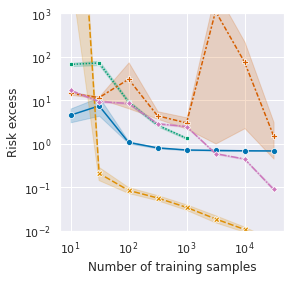

In [ ]:
# Learning curves : excess risk  

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='n',y='err_log',hue='Regressor',palette='colorblind',style='Regressor',markers=True)

plt.ylim((1e-2,1e3))
plt.legend()

plt.xscale('log')
plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'Number of training samples')
plt.savefig('MCAR.pdf',bbox_inches = 'tight')
plt.show()


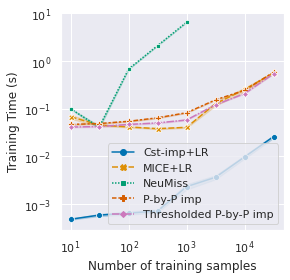

In [ ]:
# Learning curves : Training time 
sns.lineplot(data=df,x='n',y='Time',hue='Regressor',palette='colorblind',style='Regressor',markers=True)

plt.ylim()
plt.legend()


plt.xscale('log')
plt.yscale('log')


plt.ylabel('Training Time (s)')
plt.xlabel(r'Number of training samples')
plt.savefig('MCAR_time.pdf',bbox_inches = 'tight')
plt.show()


## Simulation 2: MAR

In [ ]:
d=8
p=0.5
sigma=0.5
def gen(n):
    return ToysMissingDataset(n=n,d=d,p=p,method='MAR',R=d,sigma=sigma)

b_risk=sigma**2+((0.5*p)**(d//2))*((d//2)**2)
bayes_risk(gen,int(1e5),repeat=10),b_risk

  0%|          | 0/10 [00:00<?, ?it/s]

(0.3178297751137068, 0.3125)

In [ ]:
lst_reg= [RegLin0imputation(name='Cst-imp+LR'),
          MICELR(name='MICE+LR'),
          Neumann_mlp(depth=4, n_epochs=100, batch_size=10, lr=1e-2/100),
          RegLinPatByPatTresh(name='P-by-P imp',B_dico=True,s=1/d),
          RegLinPatByPatTresh(name='Thresholded P-by-P imp',B_dico=True)]
df= df_test(lst_reg,gen,lst_p_max=[5,5,3,5,5],p_max=5,ratio=2,n_test=1000,repeat=100,b_risk=b_risk,seed=2)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

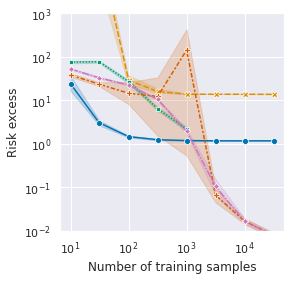

In [ ]:
sns.lineplot(data=df,x='n',y='err_log',hue='Regressor',palette='colorblind',style='Regressor',markers=True,legend=False)

plt.ylim((1e-2,1e3))



plt.xscale('log')
plt.yscale('log')

plt.ylabel('Risk excess')
plt.xlabel(r'Number of training samples')
plt.savefig('MAR.pdf',bbox_inches = 'tight')
plt.show()

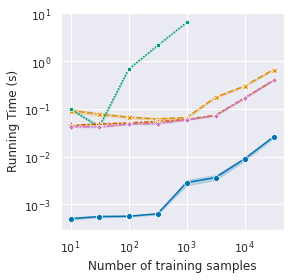

In [ ]:
sns.lineplot(data=df,x='n',y='Time',hue='Regressor',palette='colorblind',style='Regressor',markers=True,legend=False)

plt.ylim()



plt.xscale('log')
plt.yscale('log')


plt.ylabel('Running Time (s)')
plt.xlabel(r'Number of training samples')
plt.savefig('MAR_time.pdf',bbox_inches = 'tight')
plt.show()

## Simulation 3 : GMM (MNAR)

In [ ]:

dsupp=4
d=4+dsupp
B=[0 for k in range(dsupp)]
U=np.array([[ind(i,j,2) for j in range(d)] for i in range(d)])
V=np.ones((d,d))
A=[]


A.append([np.array([0,5,4,-1]+B),U,np.array([0,1,0,1]+B),0.6])
A.append([np.array([1,3,0,2]+B),V,np.array([1,0,1,1]+B),0.3])
A.append([np.array([0,5,4,-1]+B),np.identity(d),np.array([0,1,1,1]+B),0.02])
A.append([np.array([0,5,0,-1]+B),np.identity(d),np.array([1,1,0,1]+B),0.02])
A.append([np.array([0,-10,7,-1]+B),np.identity(d),np.array([1,1,0,0]+B),0.02])
A.append([np.array([0,9,0,-1]+B),np.identity(d),np.array([0,1,0,0]+B),0.02])
A.append([np.array([3,0,0,-1]+B),np.identity(d),np.array([0,0,1,0]+B),0.02])

def gen(n):
    return ToysMissingDataset(n=n,sigma=1,d=d,p=0.0,method='Database_merge',A=A,R=d)

b_risk=1+0.02*(3+3+2+1+1)
b_risk,bayes_risk(gen,int(1e5),repeat=10)

  0%|          | 0/10 [00:00<?, ?it/s]

(1.2, 1.200399613539022)

In [ ]:
lst_reg= [RegLin0imputation(name='Cst-imp+LR'),
          MICELR(name='MICE+LR'),
          Neumann_mlp(depth=4, n_epochs=100, batch_size=10, lr=1e-2/100),
          RegLinPatByPatTresh(name='P-by-P imp',B_dico=True,s=1/4),
          RegLinPatByPatTresh(name='Thresholded P-by-P imp',B_dico=True)]
df= df_test(lst_reg,gen,lst_p_max=[5,5,3,5,5],p_max=5,ratio=2,n_test=1000,repeat=100,b_risk=b_risk,seed=2)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

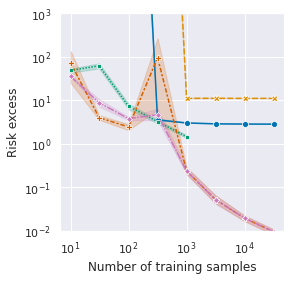

In [ ]:
sns.lineplot(data=df,x='n',y='err_log',hue='Regressor',palette='colorblind',style='Regressor',markers=True,legend=False)

plt.ylim((1e-2,1e3))

plt.xscale('log')
plt.yscale('log')


plt.ylabel(r'Risk excess')
plt.xlabel(r'Number of training samples')
plt.savefig('GMM.pdf',bbox_inches = 'tight')
plt.show()

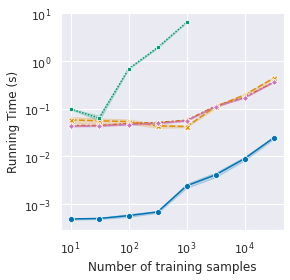

In [ ]:
sns.lineplot(data=df,x='n',y='Time',hue='Regressor',palette='colorblind',style='Regressor',legend=False,markers=True)

plt.ylim()

plt.xscale('log')
plt.yscale('log')


plt.ylabel('Running Time (s)')
plt.xlabel(r'Number of training samples')
plt.savefig('GMM_time.pdf',bbox_inches = 'tight')
plt.show()

#Illustration on Bernoulli Model

In [ ]:
# Bernoulli distribution
def facto(i):
  if i==1 or i==0:
    return 1
  else :
    return i*facto(i-1)
p_poisson=[np.exp(-1)/facto(i) for i in range(16)]


def mod_ber (epsilon):
  d=len(epsilon)
  b=np.zeros(d+1)
  res=[]
  while b[d]==0:
    p=1
    for i in range (d):
      if b[i]==1:
        p=p*epsilon[i]
      else: 
        p=p*(1-epsilon[i])
    res.append(p) 
    for i in range (d+1):
      if b[i]==1:
        b[i]=0
      else:
        b[i]=1
        break
  return res 

In [ ]:
# distribution complexity
def Ep (x,tau):
  return np.array([np.sum (x*(x<t)+t*(x>=t))for t in tau])

In [ ]:
# distribution 
p_unif= mod_ber([0.5,0.5,0.5,0.5])
p_homo2= mod_ber([0.10,0.10,0.10,0.10])
p_homo1=mod_ber([0.15,0.15,0.15,0.15])
p_hetero1=mod_ber([0.30,0.05,0.20,0.05])


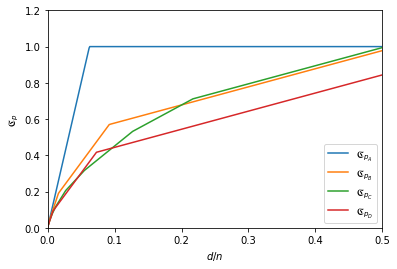

In [ ]:
# plot 
tau= np.arange(0., 0.5, 0.001)

sns.lineplot(tau,Ep (p_unif,tau),label=r"$\mathfrak{C}_{p_A}$",markers=True,palette='colorblind')
sns.lineplot(tau,Ep (p_homo1,tau), label=r"$\mathfrak{C}_{p_B}$",markers=True,palette='colorblind')
sns.lineplot(tau,Ep (p_hetero1,tau), label=r"$\mathfrak{C}_{p_C}$",markers=True,palette='colorblind')
sns.lineplot(tau,Ep (p_homo2,tau), label=r"$\mathfrak{C}_{p_D}$",markers=True,palette='colorblind')

plt.ylim((0,1.2))
plt.xlim((0,0.5))

plt.xlabel(r'$d/n$')
plt.ylabel(r'$\mathfrak{C}_p$')

plt.savefig("illustrationDiffE.pdf")
 